## 範例重點
* 學習如何在 keras 中加入 reduce learning rate
* 知道如何設定 reduce_lr 的監控目標
* 比較使用有無使用 reduce_lr 時的 performance

In [1]:
import os
from tensorflow import keras

# 本範例不需使用 GPU, 將 GPU 設定為 "無"
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
# 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# 資料前處理 - X 標準化
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# 資料前處理 - Y 轉成 onehot
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

model = build_mlp(input_shape=x_train.shape[1:])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3072)]            0         
                                                                 
 hidden_layer1 (Dense)       (None, 512)               1573376   
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 hidden_layer2 (Dense)       (None, 256)               131328    
                                                                 
 batch_normalization_1 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 hidden_layer3 (Dense)       (None, 128)               32896 

In [6]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [7]:
"""
# 載入 Callbacks, 並設定監控目標為 validation loss

參數說明：
monitor: 監控目標
min_lr: 最低下降至多少學習率
factor: 每次學習率要下降多少
patience: 經過多少 Epoch 後模型沒有改善時會使用該功能

"""
from keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(factor=0.5, 
                              min_lr=1e-12, 
                              monitor='val_loss', 
                              patience=5, 
                              verbose=1)

In [8]:
optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE)
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

history = model.fit(x_train, y_train, 
                    epochs=EPOCHS, 
                    batch_size=BATCH_SIZE, 
                    validation_data=(x_test, y_test), 
                    shuffle=True,
                    callbacks=[reduce_lr], 
                    verbose=1)

# Collect results
train_loss = model.history.history["loss"]
valid_loss = model.history.history["val_loss"]
train_acc = model.history.history["accuracy"]
valid_acc = model.history.history["val_accuracy"]

Epoch 1/50
49/49 [==============================] - 6s 108ms/step - loss: 1.7852 - accuracy: 0.3818 - val_loss: 2.5963 - val_accuracy: 0.1976 - lr: 0.0010
Epoch 2/50
49/49 [==============================] - 4s 76ms/step - loss: 1.5038 - accuracy: 0.4700 - val_loss: 1.9317 - val_accuracy: 0.3130 - lr: 0.0010
Epoch 3/50
49/49 [==============================] - 4s 77ms/step - loss: 1.4064 - accuracy: 0.5038 - val_loss: 1.7317 - val_accuracy: 0.3814 - lr: 0.0010
Epoch 4/50
49/49 [==============================] - 4s 75ms/step - loss: 1.3232 - accuracy: 0.5351 - val_loss: 1.9351 - val_accuracy: 0.3406 - lr: 0.0010
Epoch 5/50
49/49 [==============================] - 4s 85ms/step - loss: 1.2557 - accuracy: 0.5603 - val_loss: 1.6425 - val_accuracy: 0.4212 - lr: 0.0010
Epoch 6/50
49/49 [==============================] - 4s 86ms/step - loss: 1.1963 - accuracy: 0.5812 - val_loss: 1.7810 - val_accuracy: 0.3716 - lr: 0.0010
Epoch 7/50
49/49 [==============================] - 4s 78ms/step - loss: 1.

Epoch 46/50
49/49 [==============================] - 4s 78ms/step - loss: 0.3031 - accuracy: 0.9331 - val_loss: 1.6380 - val_accuracy: 0.5295 - lr: 7.8125e-06
Epoch 47/50
49/49 [==============================] - ETA: 0s - loss: 0.3027 - accuracy: 0.9332
Epoch 47: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.
49/49 [==============================] - 4s 77ms/step - loss: 0.3027 - accuracy: 0.9332 - val_loss: 1.6427 - val_accuracy: 0.5289 - lr: 7.8125e-06
Epoch 48/50
49/49 [==============================] - 4s 76ms/step - loss: 0.3011 - accuracy: 0.9347 - val_loss: 1.6416 - val_accuracy: 0.5290 - lr: 3.9063e-06
Epoch 49/50
49/49 [==============================] - 4s 80ms/step - loss: 0.3009 - accuracy: 0.9347 - val_loss: 1.6427 - val_accuracy: 0.5279 - lr: 3.9063e-06
Epoch 50/50
49/49 [==============================] - 4s 75ms/step - loss: 0.2996 - accuracy: 0.9351 - val_loss: 1.6434 - val_accuracy: 0.5286 - lr: 3.9063e-06


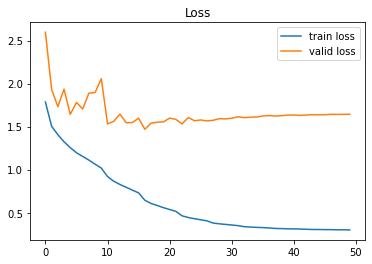

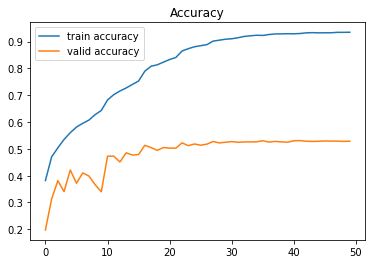

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
plt.plot(range(len(train_loss)), train_loss, label="train loss")
plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
plt.legend()
plt.title("Loss")
plt.show()

plt.figure()
plt.plot(range(len(train_acc)), train_acc, label="train accuracy")
plt.plot(range(len(valid_acc)), valid_acc, label="valid accuracy")
plt.legend()
plt.title("Accuracy")
plt.show()

## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果